In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/Colab Notebooks/data_sample

/content/drive/MyDrive/Colab Notebooks/data_sample


In [5]:
def format_img(id):
    # Charger l'image et la transformer en tableau numpy
    image = Image.open(f'./{id}.jpg')
    """
    #Taille de l'image originale
    width, height = image.size

    # Normalisation dees l'Image
    # L'image est coupée à la taille 178x178
    left = 0
    top = 20
    right = width
    bottom = 198
    image = image.crop((left, top, right, bottom))
    """
    # Choisissez une nouvelle résolution plus petite
    img_resized = image.resize((128, 128)) # Attention taille de l'image 128x128

    # -1 pour aplatir l'image, 3 pour les canaux RGB
    image_np = np.array(img_resized) # ne pas aplatir
    #image_gris=img_resized.convert('L')

    # Normaliser les valeurs des pixels
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #image_np_normalized = scaler.fit_transform(image_np)

    return image_np

In [6]:
data=[]
for i in range(1,1001):
    if i <10:
        id=f'00000{i}'
        data.append(format_img(id))
    if i<100 and i>=10:
        id=f'0000{i}'
        data.append(format_img(id))
    if i<1000 and i>=100:
        id=f'000{i}'
        data.append(format_img(id))
    print(i)
    """
    if i>=1000:
        id=f'00{i}'
        data.append(format_img(id))
    """
data=np.array(data)
print(data.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
# Permet de choisir un attribut selon son nom
attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)
print(attributes_names)

my_attribute='Male'

index = np.where(attributes_names == f"{my_attribute}")[0]  # Renvoie un tableau des indices
print(index)
my_index=index[0]+1
print(my_index)

['5_o_Clock_Shadow' 'Arched_Eyebrows' 'Attractive' 'Bags_Under_Eyes'
 'Bald' 'Bangs' 'Big_Lips' 'Big_Nose' 'Black_Hair' 'Blond_Hair' 'Blurry'
 'Brown_Hair' 'Bushy_Eyebrows' 'Chubby' 'Double_Chin' 'Eyeglasses'
 'Goatee' 'Gray_Hair' 'Heavy_Makeup' 'High_Cheekbones' 'Male'
 'Mouth_Slightly_Open' 'Mustache' 'Narrow_Eyes' 'No_Beard' 'Oval_Face'
 'Pale_Skin' 'Pointy_Nose' 'Receding_Hairline' 'Rosy_Cheeks' 'Sideburns'
 'Smiling' 'Straight_Hair' 'Wavy_Hair' 'Wearing_Earrings' 'Wearing_Hat'
 'Wearing_Lipstick' 'Wearing_Necklace' 'Wearing_Necktie' 'Young']
[20]
21


In [8]:
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:999]
genre = np.array(attributes_short[:,my_index], dtype=int)
unique, counts = np.unique(genre, return_counts=True)
unique = map(str, unique)
counts = map(int, counts)
headcounts=dict(zip(unique, counts))

# Permet de voir si la répartition est équilibrée
print(f"{my_attribute} repartition {headcounts}")

Male repartition {'-1': 567, '1': 432}


In [9]:
from keras import Model, Input

latent_dim = 8  #  latent space dimension

def build_encoder(input_shape=(128, 128, 3)):
    img_input = Input(shape=input_shape, name="encoder_image_input")
    label_input = Input(shape=(1,), name="encoder_label_input")

    # Broadcast -1/1 labels to shape=(128,128,1)
    x_label = layers.Dense(128 * 128)(label_input)
    x_label = layers.Reshape((128, 128, 1))(x_label)

    x = layers.Concatenate(axis=-1)([img_input, x_label])

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #Noyau de taille 2x2. Tester avec Conv2D kernel size = 2, stride  2 et pas de padding
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 2.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]


    encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [10]:
def build_decoder(output_shape=(128, 128, 3)):
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    label_input = Input(shape=(1,), name="decoder_label_input")

    # put latent and label together
    x = layers.Concatenate()([latent_input, label_input])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [11]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, gender_logits = self.encoder([images, labels])
            reconstruction = self.decoder([z, labels])

            # Calculate MSE
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            labels = tf.cast(labels, tf.float32)
            # Add gender_loss as a study factor
            gender_loss = tf.reduce_mean(tf.square(gender_logits - labels))  # labels: -1/1
            total_loss = reconstruction_loss + kl_loss + 1.0 * gender_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        """
        # Enregistrement des valeurs dans TensorBoard pour observer l'évolution des loss
        with summary_writer.as_default():
            tf.summary.scalar("Total Loss", total_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Reconstruction Loss", reconstruction_loss, step=self.optimizer.iterations)
            tf.summary.scalar("KL Loss", kl_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Gender Loss", gender_loss, step=self.optimizer.iterations)
        """

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "gender_loss": gender_loss,
        }

In [12]:
# L'enregistrement des loss
class LossHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Attention ：logs est un dictionnaire qui contient tous les loss return
        total_loss_history.append(logs.get("loss"))
        reconstruction_loss_history.append(logs.get("reconstruction_loss"))
        kl_loss_history.append(logs.get("kl_loss"))
        gender_loss_history.append(logs.get("gender_loss"))


In [13]:
# Génération des images pour chaque 10 epochs
class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim, epoch_interval=10):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epoch_interval == 0:
            # 每10个epoch生成两张图
            z_sample = tf.random.normal(shape=(1, self.latent_dim))

            for gender_val in [0.0, 1.0]:
                gender_label = tf.constant([[gender_val]])
                generated_img = self.decoder([z_sample, gender_label], training=False)
                img_np = generated_img[0].numpy()

                plt.figure(figsize=(2, 2))
                plt.imshow(img_np)
                plt.axis('off')
                plt.title(f"Epoch {epoch+1}, Gender: {'Male' if gender_val == 1 else 'Female'}")
                plt.show()


In [14]:
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16384)          │         32,768 │ encoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_image_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 128, 128, 1)    │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 4)    │              0 │ encoder_image_input[0… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 32)     │          1,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 256)      │        295,168 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 2, 2, 256)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 8)              │          4,104 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 8)              │          4,104 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 8)              │              0 │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 8)              │              0 │ z_mean[0][0],          │
│                      

 Total params: 954,489 (3.64 MB)

 Trainable params: 954,489 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_latent_input      │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 9)              │              0 │ decoder_latent_input[… │
│ (Concatenate)             │                        │                │ decoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16384)          │        163,840 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 256)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        295,040 │ reshape_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 64)     │         73,792 │ conv2d_transpose[0][0] │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 32)     │         18,464 │ conv2d_transpose_1[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 16)   │          4,624 │ conv2d_transpose_2[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 128, 128, 3)    │            435 │ conv2d_transpose_3[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 556,195 (2.12 MB)

 Trainable params: 556,195 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train/255
print(y_train[0:99])

[-1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1
 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1 -1
 -1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1
 -1 -1  1]


In [ ]:
"""
# Enregistrement des loss
from keras.callbacks import TensorBoard
import datetime  # Pour générer un nom unique de dossier

# Définir un dossier pour les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

with tf.device('/device:GPU:0'):  # or '/device:CPU:0' if you want to use CPU
  summary_writer = tf.summary.create_file_writer(log_dir)
# Vérifier où sont stockés les logs
print(f"Logs enregistrés dans : {log_dir}")
"""

'\n# Enregistrement des loss\nfrom keras.callbacks import TensorBoard\nimport datetime  # Pour générer un nom unique de dossier\n\n# Définir un dossier pour les logs de TensorBoard\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\nwith tf.device(\'/device:GPU:0\'):  # or \'/device:CPU:0\' if you want to use CPU\n  summary_writer = tf.summary.create_file_writer(log_dir)\n# Vérifier où sont stockés les logs\nprint(f"Logs enregistrés dans : {log_dir}") \n'

In [ ]:
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
# L'enregistrement des loss
total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
gender_loss_history = []

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - gender_loss: 1.5527 - kl_loss: 2.3193 - loss: 1520.8680 - reconstruction_loss: 1516.9634
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - gender_loss: 1.5727 - kl_loss: 1.4698 - loss: 1434.6454 - reconstruction_loss: 1431.6743
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.4417 - kl_loss: 19.0029 - loss: 1214.6185 - reconstruction_loss: 1194.1014
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.4036 - kl_loss: 10.2904 - loss: 1117.7057 - reconstruction_loss: 1105.9752
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.4668 - kl_loss: 13.7267 - loss: 1013.8492 - reconstruction_loss: 998.6577 
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.6652 - kl_loss: 15.7983 - loss: 901.3356 - reconstruction_loss: 883.9266
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.7626 - kl_loss: 20.3729 - loss: 783.7467 - reconstruction_loss: 761.6

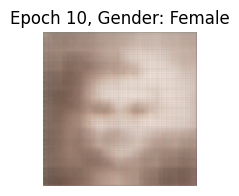

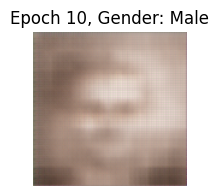

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - gender_loss: 1.7238 - kl_loss: 24.1096 - loss: 651.2909 - reconstruction_loss: 625.4884
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.7019 - kl_loss: 23.8927 - loss: 622.2754 - reconstruction_loss: 596.7069
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.6646 - kl_loss: 22.8103 - loss: 600.6892 - reconstruction_loss: 576.2203
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.6307 - kl_loss: 24.9984 - loss: 589.6599 - reconstruction_loss: 562.9962
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.6381 - kl_loss: 25.3213 - loss: 560.6412 - reconstruction_loss: 533.6659
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - gender_loss: 1.5529 - kl_loss: 23.4108 - loss: 550.7527 - reconstruction_loss: 525.8004
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 1.5517 - kl_loss: 24.2402 - loss: 546.0955 - reconstruction_loss: 520.2922
Epoch 17/100

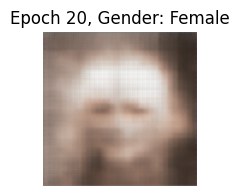

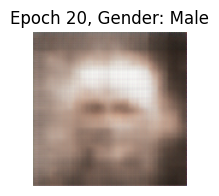

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - gender_loss: 1.4643 - kl_loss: 23.4359 - loss: 531.9800 - reconstruction_loss: 507.1015
Epoch 21/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.4274 - kl_loss: 23.6378 - loss: 503.0525 - reconstruction_loss: 477.9207
Epoch 22/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.3699 - kl_loss: 22.2628 - loss: 492.8514 - reconstruction_loss: 469.2168
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.3645 - kl_loss: 23.6156 - loss: 509.2880 - reconstruction_loss: 484.3110
Epoch 24/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.3247 - kl_loss: 22.4568 - loss: 495.8014 - reconstruction_loss: 472.0228
Epoch 25/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.2925 - kl_loss: 22.4394 - loss: 487.9512 - reconstruction_loss: 464.2604
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.2675 - kl_loss: 22.7809 - loss: 489.6474 - reconstruction_loss: 465.6094
Epoch 27/100

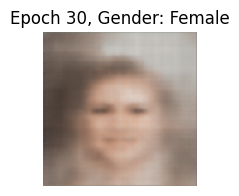

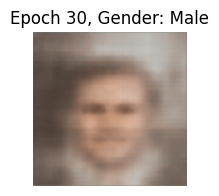

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - gender_loss: 1.1977 - kl_loss: 23.9248 - loss: 462.4723 - reconstruction_loss: 437.3341
Epoch 31/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.1612 - kl_loss: 22.9340 - loss: 471.1641 - reconstruction_loss: 447.0587
Epoch 32/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.1375 - kl_loss: 23.4897 - loss: 461.4720 - reconstruction_loss: 436.8463
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.1197 - kl_loss: 23.1699 - loss: 466.6326 - reconstruction_loss: 442.3192
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 1.0885 - kl_loss: 23.5783 - loss: 463.1018 - reconstruction_loss: 438.4283
Epoch 35/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 1.0775 - kl_loss: 23.6916 - loss: 455.5652 - reconstruction_loss: 430.8011
Epoch 36/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - gender_loss: 1.0627 - kl_loss: 22.7285 - loss: 454.5262 - reconstruction_loss: 430.7123
Epoch 37/100

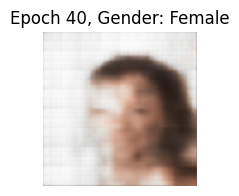

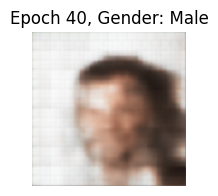

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - gender_loss: 1.0055 - kl_loss: 23.5109 - loss: 439.8239 - reconstruction_loss: 415.2745
Epoch 41/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.0144 - kl_loss: 23.7784 - loss: 431.1591 - reconstruction_loss: 406.3598
Epoch 42/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 1.0001 - kl_loss: 23.1474 - loss: 415.3663 - reconstruction_loss: 391.2237
Epoch 43/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9940 - kl_loss: 22.9380 - loss: 421.0795 - reconstruction_loss: 397.1686
Epoch 44/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9965 - kl_loss: 23.2944 - loss: 420.4836 - reconstruction_loss: 396.1864
Epoch 45/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9948 - kl_loss: 23.3239 - loss: 414.3132 - reconstruction_loss: 390.0000
Epoch 46/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9907 - kl_loss: 24.0294 - loss: 410.7547 - reconstruction_loss: 385.7572
Epoch 47/100

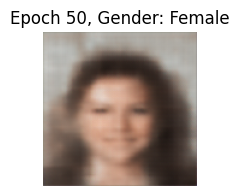

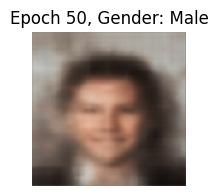

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - gender_loss: 0.9848 - kl_loss: 23.8608 - loss: 452.1548 - reconstruction_loss: 427.2898
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 0.9819 - kl_loss: 23.6220 - loss: 435.1687 - reconstruction_loss: 410.5660
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9780 - kl_loss: 23.5479 - loss: 426.8578 - reconstruction_loss: 402.3227
Epoch 53/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9809 - kl_loss: 24.3032 - loss: 422.3929 - reconstruction_loss: 397.1242
Epoch 54/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9770 - kl_loss: 24.4234 - loss: 417.9899 - reconstruction_loss: 392.5871
Epoch 55/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9777 - kl_loss: 25.2426 - loss: 427.9394 - reconstruction_loss: 401.7138
Epoch 56/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - gender_loss: 0.9815 - kl_loss: 25.2255 - loss: 415.2959 - reconstruction_loss: 389.0941
Epoch 57/100

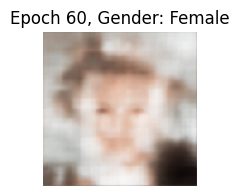

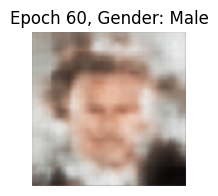

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - gender_loss: 0.9746 - kl_loss: 24.7025 - loss: 385.5326 - reconstruction_loss: 359.8639
Epoch 61/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9740 - kl_loss: 24.0021 - loss: 388.1622 - reconstruction_loss: 363.1834
Epoch 62/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9750 - kl_loss: 24.3622 - loss: 378.0907 - reconstruction_loss: 352.7512
Epoch 63/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 0.9752 - kl_loss: 23.8392 - loss: 379.0175 - reconstruction_loss: 354.1911
Epoch 64/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9826 - kl_loss: 23.6581 - loss: 373.8193 - reconstruction_loss: 349.1981
Epoch 65/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9865 - kl_loss: 24.5158 - loss: 365.8628 - reconstruction_loss: 340.3705
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9806 - kl_loss: 23.5988 - loss: 366.2051 - reconstruction_loss: 341.6204
Epoch 67/100

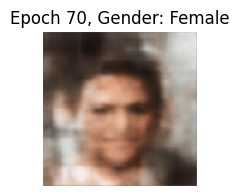

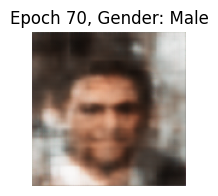

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - gender_loss: 0.9813 - kl_loss: 24.3556 - loss: 358.9420 - reconstruction_loss: 333.6178
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9725 - kl_loss: 24.4206 - loss: 345.2002 - reconstruction_loss: 319.8224
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9787 - kl_loss: 25.0463 - loss: 334.0062 - reconstruction_loss: 307.9943
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9706 - kl_loss: 24.6675 - loss: 330.7340 - reconstruction_loss: 305.0915
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9716 - kl_loss: 24.9126 - loss: 341.1145 - reconstruction_loss: 315.2276
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9801 - kl_loss: 23.8017 - loss: 338.7148 - reconstruction_loss: 313.9475
Epoch 76/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9783 - kl_loss: 24.6912 - loss: 333.0830 - reconstruction_loss: 307.4086
Epoch 77/100

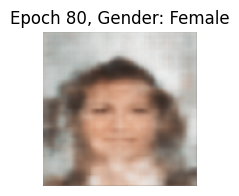

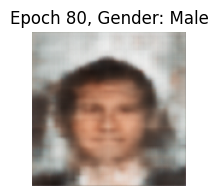

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - gender_loss: 0.9805 - kl_loss: 24.9794 - loss: 316.7083 - reconstruction_loss: 290.7626
Epoch 81/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9784 - kl_loss: 25.2145 - loss: 315.0894 - reconstruction_loss: 288.8848
Epoch 82/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - gender_loss: 0.9738 - kl_loss: 25.1531 - loss: 319.1988 - reconstruction_loss: 293.0641
Epoch 83/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9807 - kl_loss: 24.7325 - loss: 308.2162 - reconstruction_loss: 282.5230
Epoch 84/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9804 - kl_loss: 25.0109 - loss: 308.4367 - reconstruction_loss: 282.4558
Epoch 85/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9792 - kl_loss: 24.6417 - loss: 309.8090 - reconstruction_loss: 284.2024
Epoch 86/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9775 - kl_loss: 24.7797 - loss: 308.6311 - reconstruction_loss: 282.8635
Epoch 87/100

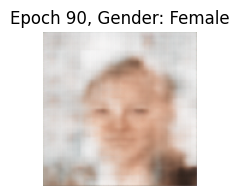

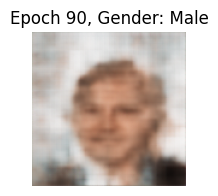

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - gender_loss: 0.9753 - kl_loss: 25.0742 - loss: 301.7662 - reconstruction_loss: 275.7089
Epoch 91/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9759 - kl_loss: 24.7119 - loss: 299.9473 - reconstruction_loss: 274.2477
Epoch 92/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9751 - kl_loss: 24.1411 - loss: 305.5589 - reconstruction_loss: 280.4194
Epoch 93/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 0.9802 - kl_loss: 24.4241 - loss: 302.5328 - reconstruction_loss: 277.1279
Epoch 94/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - gender_loss: 0.9760 - kl_loss: 24.7103 - loss: 294.6962 - reconstruction_loss: 268.9947
Epoch 95/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9772 - kl_loss: 25.2865 - loss: 292.3206 - reconstruction_loss: 266.0617
Epoch 96/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - gender_loss: 0.9781 - kl_loss: 25.0331 - loss: 299.3666 - reconstruction_loss: 273.3531
Epoch 97/100

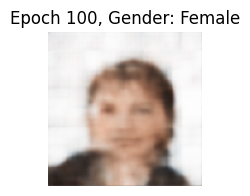

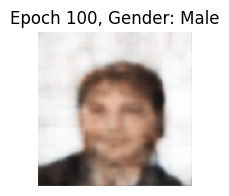

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - gender_loss: 0.9751 - kl_loss: 25.2330 - loss: 277.9086 - reconstruction_loss: 251.6959


In [18]:
# Construction du CVAE
cvae = CVAE(encoder, decoder)

# Initialiser les callbacks
history_callback = LossHistoryCallback() # Pour enregistrer les loss
gen_callback = GenerateImageCallback(decoder, latent_dim=8, epoch_interval=10) # Pour observer la qualité d'images générées chaque 10 epochs

# Fit le modèle
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, y_train, epochs=100, batch_size=32, callbacks=[history_callback, gen_callback])

#cvae.fit(x_t, y_train, epochs=100, batch_size=32, callbacks=[tensorboard_callback]) Ne marche pas encore...

In [ ]:
"""
# Affichage des loss avec TensorBoard
# --> Vérifier la convergence
%load_ext tensorboard
%tensorboard --logdir logs/fit
"""

'\n# Affichage des loss avec TensorBoard\n# --> Vérifier la convergence\n%load_ext tensorboard\n%tensorboard --logdir logs/fit\n'

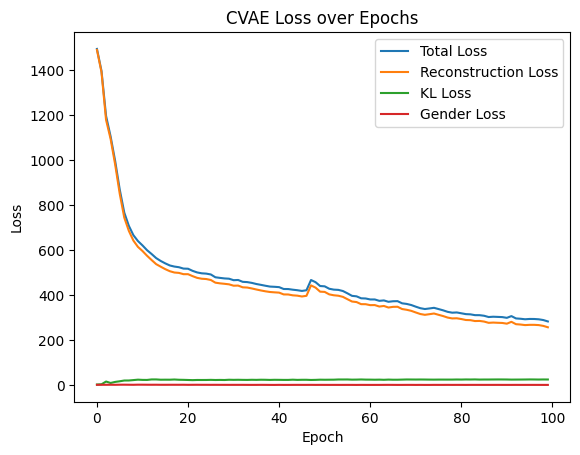

In [19]:
# Plot the loss as graphic
# import matplotlib.pyplot as plt

plt.plot(total_loss_history, label="Total Loss")
plt.plot(reconstruction_loss_history, label="Reconstruction Loss")
plt.plot(kl_loss_history, label="KL Loss")
plt.plot(gender_loss_history, label="Gender Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CVAE Loss over Epochs")
plt.show()

Le loss est décroissant en général, reconstruction loss toujours en diminution, KL loss et gender loss sont déjà bien convergents.

In [20]:
z_mean, _, _, _ = cvae.encoder.predict([x_test, y_test], batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


In [21]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN : {np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN : 0 / 330


In [22]:
print(z_mean[:1])

[[ 104.11197  -142.57877   -53.10802   101.551506   82.61152   -84.11381
    59.041428   48.999   ]]


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


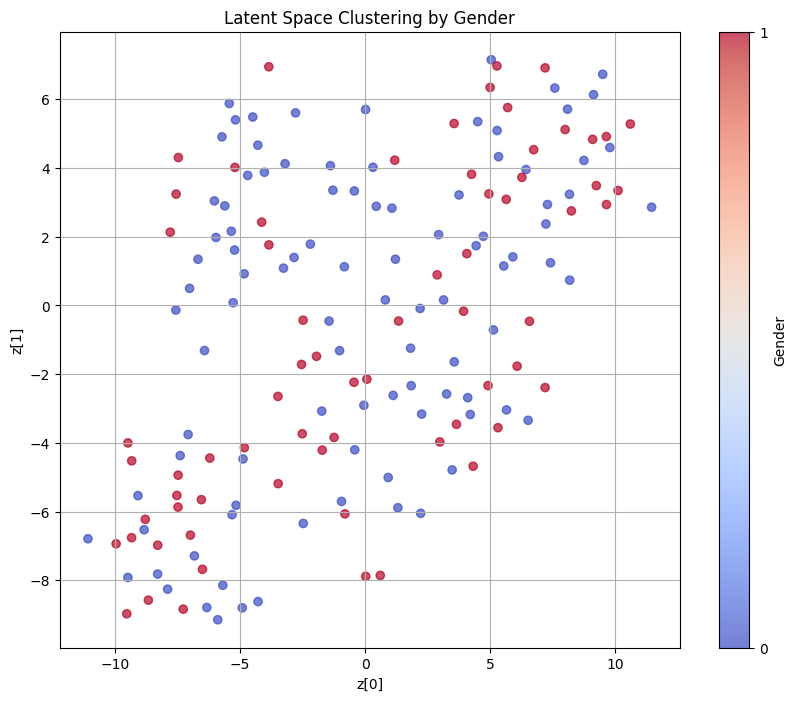

In [ ]:
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


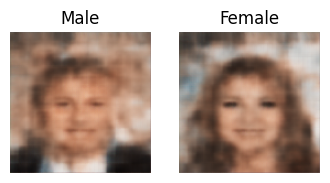

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
latent_dim = 8
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()